# NN Classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
from tensorflow import keras

## Pre-processing

Load and pre-process the dataset:

In [4]:
from lib import pre_processing
file_path = "./data/features_3_sec.csv"
df = pd.read_csv(file_path)
df = pre_processing(df)

## Data Normalization

In [5]:
from lib import normalize_df
df = normalize_df(df)

In [6]:
df_numpy = df.to_numpy()
X = df_numpy[:,:-1].astype(np.float32)
y = df_numpy[:, -1]

In [7]:
X.shape, y.shape

((9990, 57), (9990,))

## Label pre-processing

In [8]:
from lib import encode_labels
y_ohe = encode_labels(y)

In [9]:
X.shape, y_ohe.shape

((9990, 57), (9990, 10))

# Loading the models

The models were already created and saved in another notebook.

Here we just have to load them.

In [10]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [11]:
batch_sizes = {
    'multiclass': 5,
    'blues':     5,
    'classical': 15,
    'country':   20,
    'disco':     5,
    'hiphop':    15,
    'jazz':      30,
    'metal':     15,
    'pop':       50,
    'reggae':    25,
    'rock':      20
}

## Model Evaluation

In [12]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=25,
        verbose=0,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=5,
        verbose=0,
        min_lr=1e-7
    ),
    keras.callbacks.TerminateOnNaN()
]

In [13]:
# Connect to the database
from pymongo import MongoClient
client = MongoClient('localhost', 27018)
db = client['nn_training']
collection = db['musical_genre_evaluation']

In [14]:
from sklearn.model_selection import train_test_split
from keras.models import load_model

def train_static(X, y, test_size, genre, verbose=0, use_db=True):
    model = load_model('models/' + genre)
    
    # Document structure
    json = {
        "genre": genre,
        "type": "train_validation_split",
        "test_size": test_size
    }

    # Check into the DB if this configuration was already trained
    if use_db is False or collection.count_documents(json) == 0:
        # Not trained yet, train now
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
        model.fit(X_train, y_train, epochs=150, validation_data = (X_test, y_test), batch_size=batch_sizes[genre], callbacks=callbacks, verbose=verbose)
        accuracy = float(model.get_metrics_result()['accuracy'])

        # Log the result to the DB
        if use_db is True:
            json["validation_accuracy"] = accuracy
            collection.insert_one(json)

        return accuracy

    else:
        # Already trained, retrieve the accuracy
        accuracy = collection.find_one(json)['validation_accuracy']
        return accuracy

In [15]:
from sklearn.model_selection import KFold

def train_dynamic(X, y, fold, genre, verbose=0, use_db=True):
    # Document structure
    json = {
        "genre": genre,
        "type": "cross-validation",
        "fold": fold
    }

    # Check into the DB if this configuration was already trained
    if use_db is False or collection.count_documents(json) == 0:
        # Not trained yet, train now
        accuracy_list = []
        kf = KFold(n_splits=fold, shuffle=True, random_state=0)

        for train, test in kf.split(X):
            model = load_model('models/' + genre)
            X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]                
            model.fit(X_train, y_train, epochs=150, validation_data = (X_test, y_test), batch_size=batch_sizes[genre], callbacks=callbacks, verbose=verbose)
            accuracy = float(model.get_metrics_result()['accuracy'])
            accuracy_list.append(accuracy)

        avg_accuracy = np.mean(accuracy_list)

        # Log the result to the DB
        if use_db is True:
            json["validation_accuracy"] = avg_accuracy
            collection.insert_one(json)

        return avg_accuracy
        
    else:
        # Already trained, retrieve the accuracy
        avg_accuracy = collection.find_one(json)['validation_accuracy']
        return avg_accuracy

## Static partitioning (train-validation split)

In [16]:
test_sizes = [0.1, 0.25, 0.33]

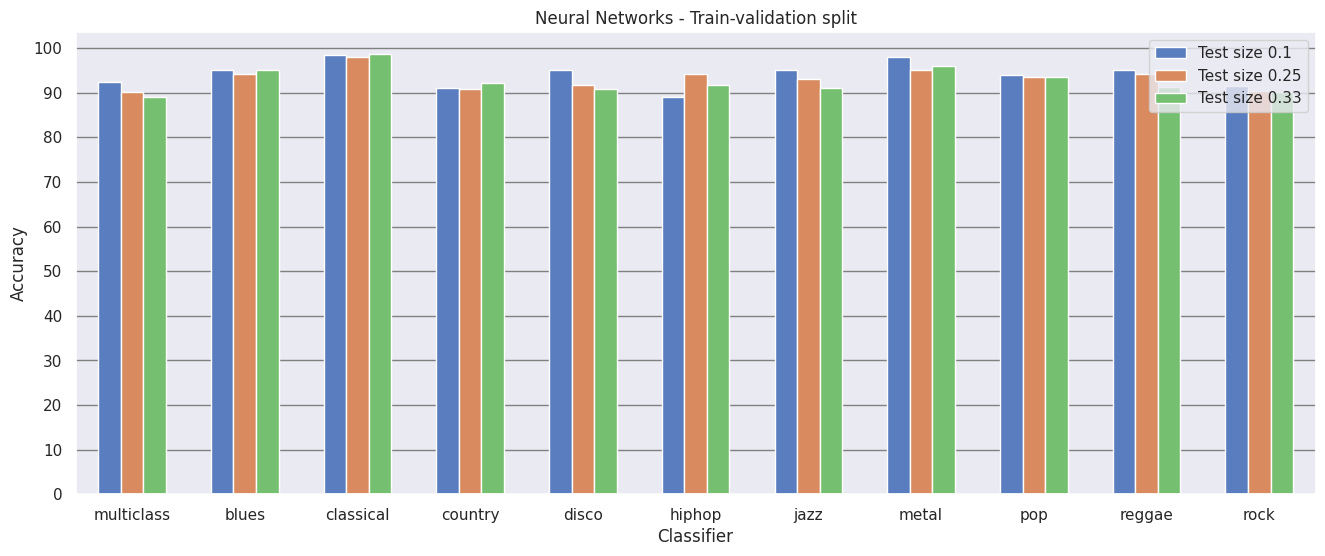

In [17]:
from lib import plot_evaluation_results, balance_classes
sp_results = []

for test_size in test_sizes:
    # Multiclass classifier
    accuracy = train_static(X, y_ohe, test_size, 'multiclass')
    sp_results.append(('multiclass', accuracy*100, f'Test size {test_size}'))
    
    # Binary classifiers
    for genre in genres:
        Xi, yi = balance_classes(X, y, genre)
        accuracy = train_static(Xi, yi, test_size, genre, verbose=0)
        sp_results.append((genre, accuracy*100, f'Test size {test_size}'))
    
# Plot
results_df = pd.DataFrame(sp_results, columns=['label', 'accuracy', 'size'])
plot_evaluation_results(results_df, "Neural Networks - Train-validation split")

## Dynamic partitioning (cross-validation)

In [18]:
folds = [5, 10, 20]

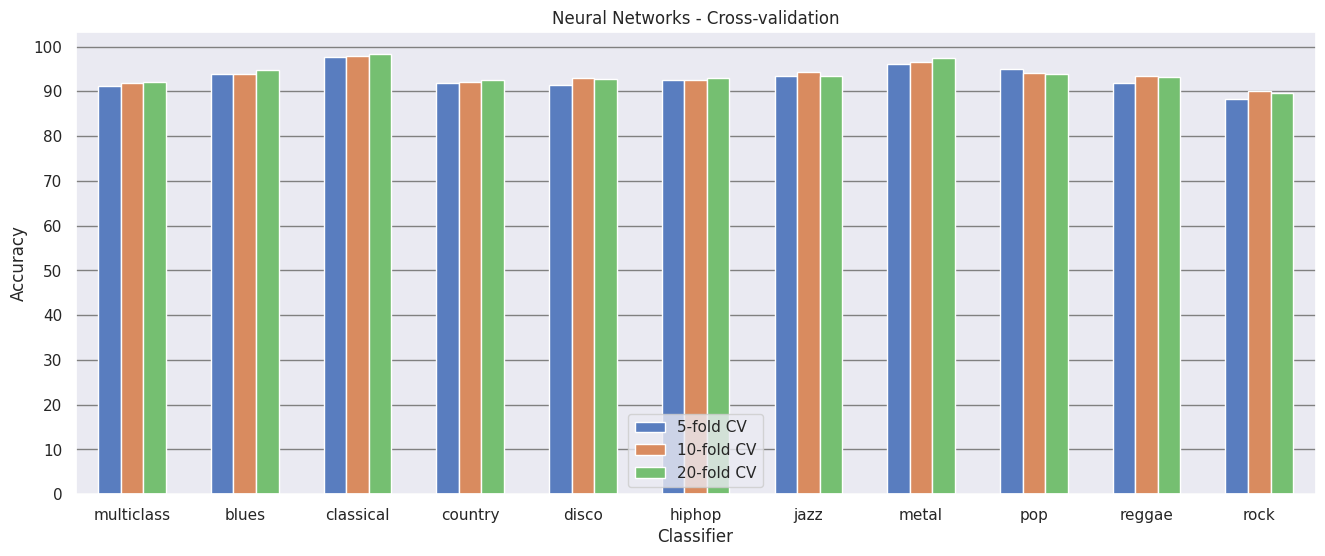

In [19]:
sp_results = []

for fold in folds:
    # Multiclass classifier
    accuracy = train_dynamic(X, y_ohe, fold, 'multiclass')
    sp_results.append(('multiclass', accuracy*100, f'{fold}-fold CV'))
    
    # Binary classifiers
    for genre in genres:
        Xi, yi = balance_classes(X, y, genre)
        accuracy = train_dynamic(Xi, yi, fold, genre)
        sp_results.append((genre, accuracy*100, f'{fold}-fold CV'))
    
# Plot
results_df = pd.DataFrame(sp_results, columns=['label', 'accuracy', 'size'])
plot_evaluation_results(results_df, "Neural Networks - Cross-validation")

# Multiclass confusion matrix

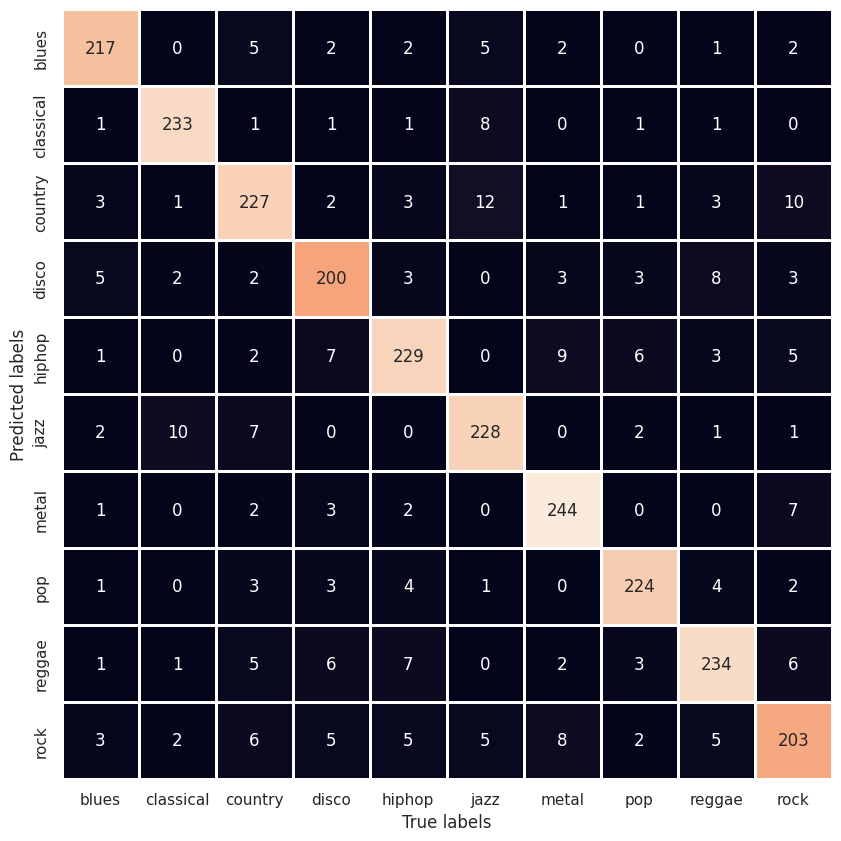

In [20]:
from lib import plot_confusion_matrix
model = load_model('models/multiclass')
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.25, random_state=0)
model.fit(X_train, y_train, epochs=150, validation_data = (X_test, y_test), batch_size=batch_sizes['multiclass'], callbacks=callbacks, verbose=0)
y_pred = model(X_test)
plot_confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=-1), genres)

# Methods comparison

Comparison of the performance of all classifiers using 20-fold cross-validation.

In [21]:
genres =  ['multiclass'] + genres

In [22]:
def create_df(model_name, values):
    return [ (model_name, genre, value) for genre, value in zip(genres, values) ]

In [23]:
accuracies = {
    'Naive Bayes': [51.992144288577144, 75.30000000000001, 92.18838383838384, 75.07676767676769, 72.62323232323233, 75.89444444444443, 80.4, 86.6, 86.15, 80.45, 70.1939393939394],
    'VFI': [48.56879759519038, 78.99999999999999, 89.62626262626262, 70.71464646464646, 73.92323232323233, 77.4449494949495, 78.95, 86.6, 86.75, 80.7, 69.2969696969697],
    'CART decision trees': [66.88733466933867, 84.14999999999999, 93.88989898989898, 78.47828282828283, 83.93484848484849, 84.42222222222222, 86.6, 91.64999999999999, 88.69999999999999, 83.64999999999998, 78.16161616161617],
    'K-Nearest Neighbors': [91.97192384769541, 95.4, 96.89545454545453, 91.47424242424243, 93.04343434343436, 94.19343434343433, 94.05000000000001, 97.35, 94.60000000000001, 95.00000000000001, 91.83686868686868],
    'Neural Networks': [92.15222507715225, 94.8500007390976, 98.29798072576523, 92.63181865215302, 92.69141405820847, 92.98181891441345, 93.34999978542328, 97.35000103712082, 93.9000004529953, 93.20000022649765, 89.62727278470993]
}

In [24]:
df_accuracies = create_df('Naive Bayes', accuracies['Naive Bayes'])
for k,v in accuracies.items():
    df_accuracies = np.concatenate([df_accuracies, create_df(k , v)])

In [25]:
df = pd.DataFrame(df_accuracies, columns=['size', 'label', 'accuracy'])
df['accuracy'] = df['accuracy'].astype('float')

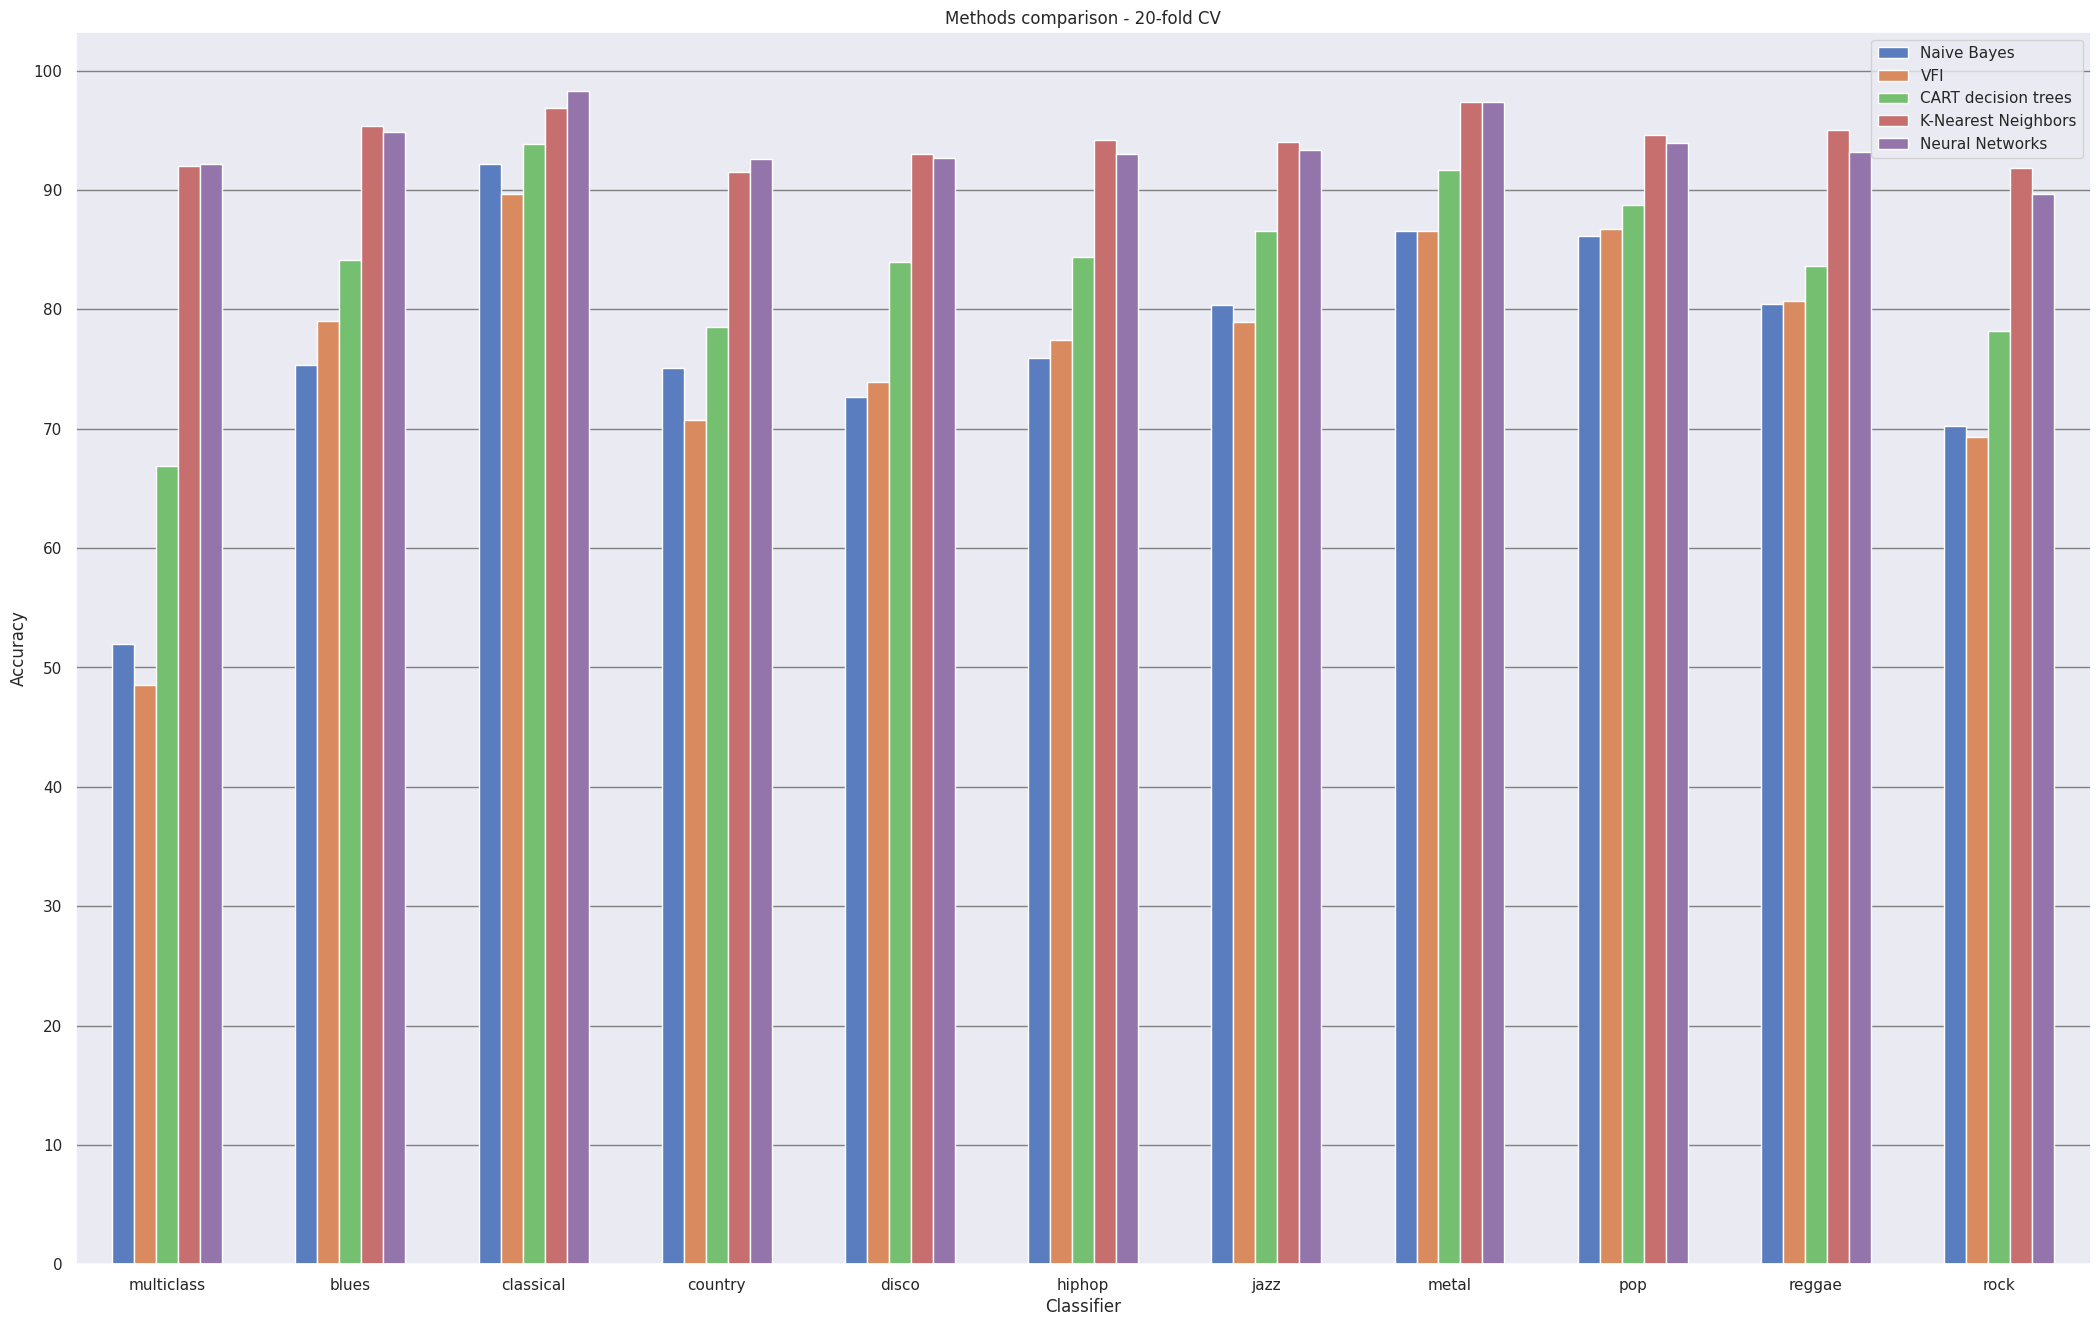

In [26]:

plot_evaluation_results(df, "Methods comparison - 20-fold CV", figsize=(26,16))